In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 5
import numpy as np
np.random.seed(0)
from pyha import *
import scipy
from scipy import signal

import warnings
warnings.filterwarnings('ignore') # because they include system path -> fails unit tests on different computer

simulations = ['MODEL', 'HARDWARE']

# Applications

In [3]:
from pyha.cores import QuadratureDemodulator
from pyha.cores.util import *
plt.rcParams['figure.figsize'] = 15, 5

## Analog FM demodulator

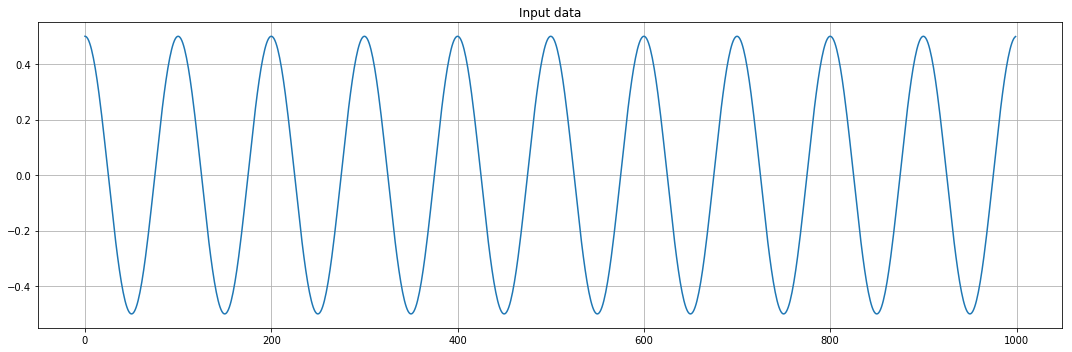

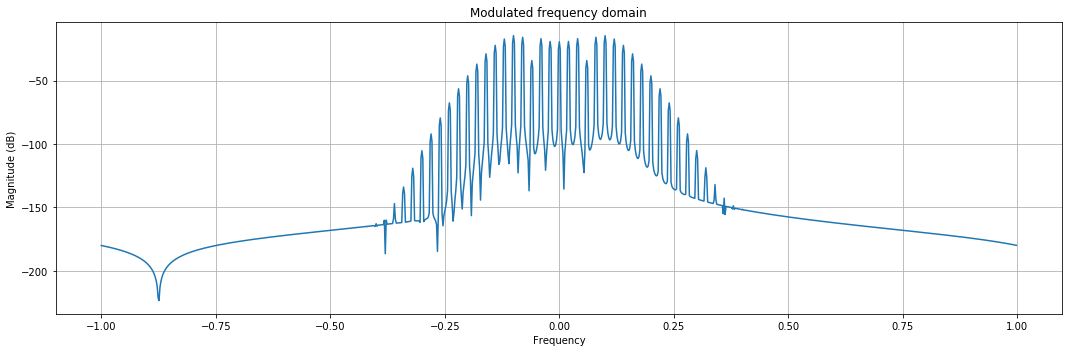

In [4]:
""" Amplitude modulated chirp signal """
fs = 1e3
deviation = fs / 8
periods = 1
data_freq = 10
time = np.linspace(0, periods, fs * periods, endpoint=False)
data = np.cos(2 * np.pi * data_freq * time) * 0.5

# modulate
sensitivity = 2 * np.pi * deviation / fs
phl = np.cumsum(sensitivity * data)
modulated_signal = np.exp(phl * 1j) * 0.5
plt.title('Input data')
plt.plot(data)
show_plot()

plt.title('Modulated frequency domain')
plt.magnitude_spectrum(modulated_signal, scale='dB')
show_plot()

In [5]:
# NBVAL_IGNORE_OUTPUT
demod_gain = fs / (2 * np.pi * deviation)
dut = QuadratureDemodulator(demod_gain)
sims = simulate(dut, modulated_signal, simulations=simulations, discard_last_n_outputs=1)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


  0%|          | 0/1019 [00:00<?, ?it/s]

100%|██████████| 1019/1019 [00:00<00:00, 2078.21it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


In [6]:
assert sims_close(sims, rtol=1e-2, atol=1e-4)

INFO:sim:sims_close(rtol=0.01, atol=0.0001)
INFO:sim:Using "MODEL" as golden output
INFO:sim:MODEL OK!
INFO:sim:PYHA OK!


In [7]:
print(f"SNR: {snr(sims['MODEL'][:-1], sims['HARDWARE'][:-1])} dB")

SNR: 70.92716784673064 dB


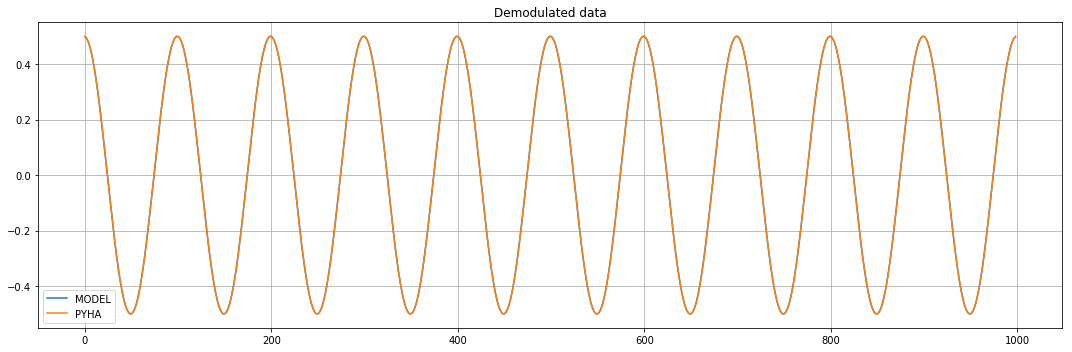

In [8]:
plt.title('Demodulated data')
for key, value in sims.items():
    plt.plot(value, label=key)
show_plot()

## FSK demodulator


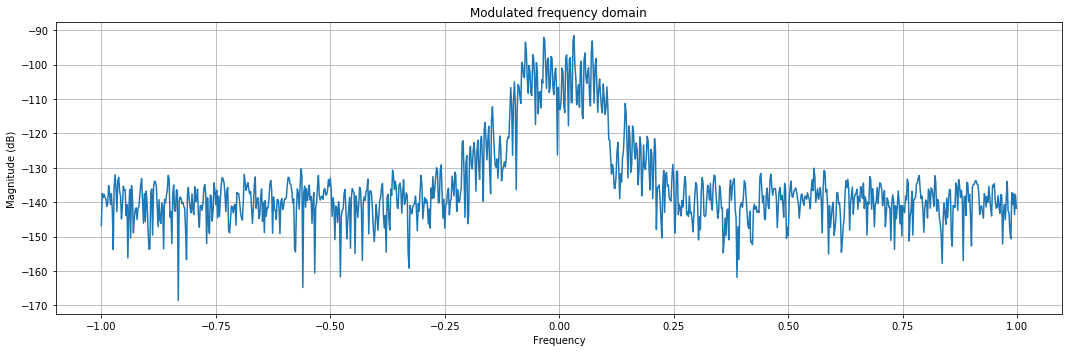

In [9]:
import inspect
import os
file = os.path.dirname(inspect.getfile(QuadratureDemodulator)) + '/phantom2_bits_bladerf.npy'
iq = np.load(file)
iq *= 0.0001 # very low power signal

iq = [Complex(x, 0, -17).val for x in iq]
plt.title('Modulated frequency domain')
plt.magnitude_spectrum(iq, scale='dB')
show_plot()

In [10]:
# NBVAL_IGNORE_OUTPUT
demod_gain = 1/np.pi*10
dut = QuadratureDemodulator(demod_gain)
sims = simulate(dut, iq, simulations=simulations,  discard_last_n_outputs=1)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


  0%|          | 0/1019 [00:00<?, ?it/s]

 81%|████████▏ | 828/1019 [00:00<00:00, 2063.99it/s]

100%|██████████| 1019/1019 [00:00<00:00, 2070.44it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


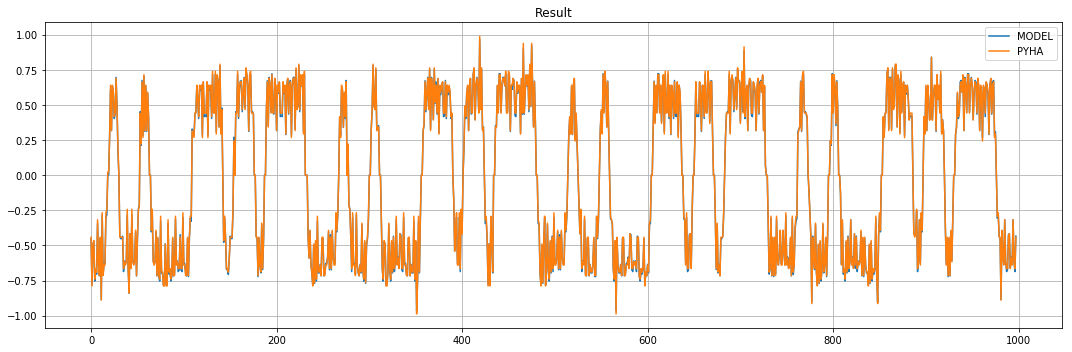

In [11]:
plt.title('Result')
for key, value in sims.items():
    plt.plot(value[:-1], label=key)
show_plot()

In [12]:
print(f"SNR: {snr(sims['MODEL'], sims['HARDWARE'])} dB")

SNR: 33.97727619674771 dB


# Limitations

## Fixed-point
Expects standard FPGA Fixed point format i.e 18 bits (incl. sign) and scaled to -1...1 range.

In [13]:
print(f'Minimum number representabe: {2**-17}')

Minimum number representabe: 7.62939453125e-06


## Cant match the model on low-power noise signal

In [14]:
N = 128
iq = (np.random.normal(size=N) + np.random.normal(size=N) * 1j) * 0.00001

In [15]:
# NBVAL_IGNORE_OUTPUT
demod_gain = 1/np.pi
dut = QuadratureDemodulator(demod_gain)
sims = simulate(dut, iq, simulations=simulations, discard_last_n_outputs=1)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 147/147 [00:00<00:00, 2118.14it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


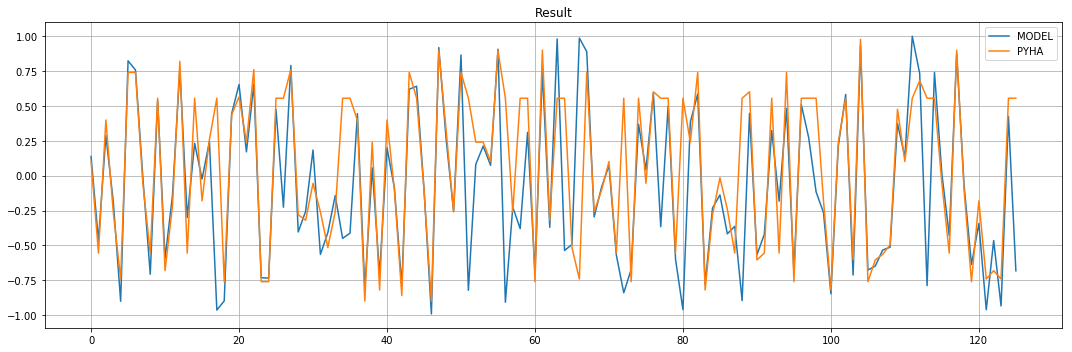

In [16]:
plt.title('Result')
for key, value in sims.items():
    plt.plot(value[:-1], label=key)
show_plot()

## Last output sample is junk
use `simulate(..., discard_last_n_outputs=1)` to get rid of it.

# Synthesis

In [17]:
# NBVAL_SKIP
dut = QuadratureDemodulator(demod_gain)
sims = simulate(dut, iq, simulations=['HARDWARE', 'RTL', 'GATE'], discard_last_n_outputs=1)

assert hardware_sims_equal(sims)

lut, mem, mul = get_resource_usage()
print(f'Logic elements: {lut}')
print(f'Memory: {mem}')
print(f'Multipler (18bit): {mul//2}')

INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 147/147 [00:00<00:00, 588.60it/s]

INFO:sim:OK!
INFO:sim:Running "RTL" simulation...
INFO:conversion:Creating top.vhd ...
INFO:conversion:Cordic to VHDL ...


INFO:conversion:ToPolar to VHDL ...
INFO:conversion:Angle to VHDL ...
INFO:conversion:QuadratureDemodulator to VHDL ...
INFO:sim:Running COCOTB & GHDL simulation....
INFO:sim:OK!
INFO:sim:Running "GATE" simulation...
INFO:conversion:Creating top.vhd ...
INFO:conversion:Cordic to VHDL ...
INFO:conversion:ToPolar to VHDL ...
INFO:conversion:Angle to VHDL ...
INFO:conversion:QuadratureDemodulator to VHDL ...
INFO:sim:Running quartus map...will take time.
INFO:sim:Analysis & Synthesis Status : Successful - Fri Aug 24 13:45:15 2018
INFO:sim:Quartus Prime Version : 18.0.0 Build 614 04/24/2018 SJ Lite Edition
INFO:sim:Revision Name : quartus_project
INFO:sim:Top-level Entity Name : top
INFO:sim:Family : Cyclone IV E
INFO:sim:Total logic elements : 2,533
INFO:sim:    Total combinational functions : 2,479
INFO:sim:    Dedicated logic registers : 1,520
INFO:sim:Total registers : 1520
INFO:sim:Total pins : 56
INFO:sim:Total virtual pins : 0
INFO:sim:Total memory bits : 0
INFO:sim:Embedded Multipl

Logic elements: 2533
Memory: 0
Multipler (18bit): 4
